## **Assignment 3 - Systematic Investments**

### **Predicting the Equity Premium**

53127 - Miguel Teodoro


In [1]:
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt

In [2]:
def plot_cumulative_returns(df, column1, column2, label1, label2):
    """
    Plots the cumulative returns of two logarithmic return columns in a pandas dataframe.
    """

    plt.rcParams["figure.figsize"] = (10,8)

    # Calculate the cumulative sum of the logarithmic returns for each column
    cumulative_return1 = (1 + df[column1]).cumprod() - 1
    cumulative_return2 = (1 + df[column2]).cumprod() - 1

    # Get the dates for each cumulative return
    dates = df['yyyymm']

    # Plot the cumulative returns for each column
    plt.plot(dates, cumulative_return1, label=label1, color="seagreen")
    plt.plot(dates, cumulative_return2, label=label2, color="royalblue")

    # Add a legend and title to the plot
    plt.legend()
    plt.title("Cumulative Returns of {} and {}".format(label1, label2))

    # Show the plot
    plt.show()

In [3]:
data = pd.read_excel('data_assignment3_si.xlsx')

In [4]:
from datetime import datetime

data['yyyymm'] = pd.to_datetime(data.yyyymm, format="%Y%m")

In [5]:
data_original = data.copy()
data = data.iloc[:,:4]

### **1.** What is the root mean squared error (RMSE) of your forecast versus the RMSE of a forecasts based on the historical mean return?

In [6]:
# Transform dividends and earnings to monthly data

data['D12'] = data['D12']/12
data['E12'] = data['E12']/12

In [7]:
# Create 20 year moving average to predict earnings growth

# Create earnings growth column
data['EG'] =  data['E12'].pct_change()

# Create MA column
data['EG_MA'] = data.EG.rolling(window=12*20, closed='left').mean()

In [8]:
# Calculate DP as ln(1 + current DP)

# Create current DP column
data['DP'] = data['D12']/data['Index']

# Create DP estimation
data['est_DP'] = np.log(1+ data['DP'].shift(1))

In [9]:
# Create 5 year moving average to predict PE Ratio Growth

# Create Price-to-Earnings column
data['PE'] =  data['Index']/data['E12']

# Create Price-to-Earnings Growth column
data['PEG'] = data.PE.pct_change()

# Create MA PE column
data['PE_MA'] = data.PE.rolling(window=12*5, closed='left').mean()

# Create PE Growth Estimate column
data['est_PEG'] = ((data['PE_MA'].shift(1) / data['PE'].shift(1)) - 1) / (12*5)

In [10]:
# Compute simple return calculation function with assumption that PER Growth = 0

def simple_return_forecast(obs):
    dp_ratio = obs['est_DP']
    e_growth = obs['EG_MA']
    pe_ratio_growth = 0
    return_t1 = ((1+dp_ratio) * (1+e_growth) * (1+pe_ratio_growth)) - 1
    return return_t1

In [11]:
# Compute return calculation with assumption that PER mean-reverts

def mr_return_forecast(obs):
    dp_ratio = obs['est_DP']
    e_growth = obs['EG_MA']
    pe_ratio_growth = obs['est_PEG']
    return_t1 = ((1+dp_ratio) * (1+e_growth) * (1+pe_ratio_growth)) - 1
    return return_t1

In [12]:
# Compute return calculation with actual values (real-time)

def actual_estimate(obs):
    dp_ratio = obs['DP']
    e_growth = obs['EG']
    pe_ratio_growth = obs['PEG']
    return_t1 = ((1+dp_ratio) * (1+e_growth) * (1+pe_ratio_growth)) - 1
    return return_t1

In [13]:
# Apply all return calculations

data['r_actual'] = np.log(data.Index) - np.log(data.Index.shift(1))
data['simple_forecast'] = data.apply(lambda x: simple_return_forecast(x), axis=1)
data['mr_forecast'] = data.apply(lambda x: mr_return_forecast(x), axis=1)
data['mean20y_forecast'] = data.r_actual.rolling(window=12*20, closed='left').mean()
data['actual_estimate'] = data.apply(lambda x: actual_estimate(x), axis=1)

In [14]:
from sklearn.metrics import r2_score, mean_squared_error

pred_data = data.dropna()

In [15]:
pred_data.head(5)

,yyyymm,Index,D12,E12,EG,EG_MA,DP,est_DP,PE,PEG,PE_MA,est_PEG,r_actual,simple_forecast,mr_forecast,mean20y_forecast,actual_estimate
241,1891-02-01,4.90,0.018333,0.024858,0.013936,-0.001189,0.003741,0.003781,197.116996,-0.001518,210.085200,0.001111,0.012320,0.002587,0.003701,0.000359,0.016185
242,1891-03-01,4.81,0.018333,0.025208,0.014080,-0.001131,0.003812,0.003735,190.809917,-0.031997,209.584769,0.001096,-0.018538,0.002600,0.003699,0.000355,-0.014626
243,1891-04-01,4.97,0.018333,0.025558,0.013884,-0.001072,0.003689,0.003804,194.457124,0.019114,209.122829,0.001640,0.032723,0.002728,0.004373,0.000177,0.037076
244,1891-05-01,4.95,0.018333,0.025900,0.013368,-0.001014,0.003704,0.003682,191.119691,-0.017163,208.832747,0.001257,-0.004032,0.002664,0.003924,0.000197,-0.000335
245,1891-06-01,4.85,0.018333,0.026250,0.013514,-0.000959,0.003780,0.003697,184.761905,-0.033266,208.614685,0.001545,-0.020409,0.002735,0.004284,0.000076,-0.016498


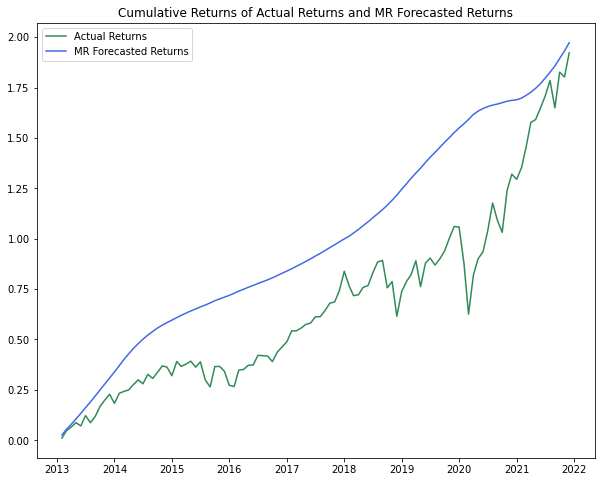

In [16]:
plot_cumulative_returns(pred_data[pred_data.yyyymm > "01-01-2013"], 'r_actual', 'mr_forecast', 'Actual Returns', 'MR Forecasted Returns')

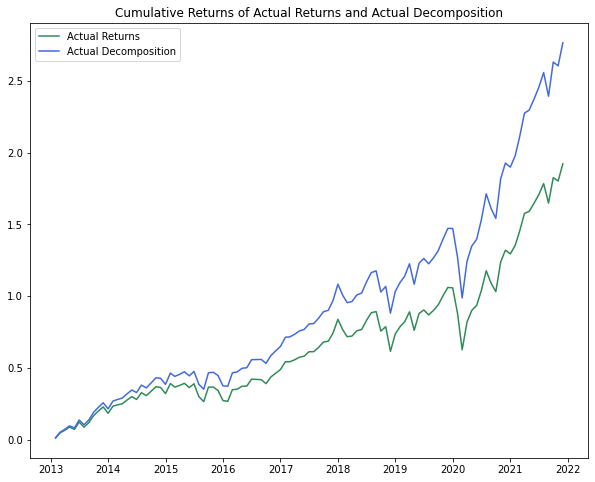

In [17]:
plot_cumulative_returns(pred_data[pred_data.yyyymm > "01-01-2013"], 'r_actual', 'actual_estimate', 'Actual Returns', 'Actual Decomposition')

In [18]:
print(f'RMSE Simple Forecast: {round(mean_squared_error(pred_data.r_actual, pred_data.simple_forecast, squared=False),4)}')
print(f'RMSE Mean-Reverse Forecast: {round(mean_squared_error(pred_data.r_actual, pred_data.mr_forecast, squared=False),4)}')
print(f'RMSE Historical 20y Mean-Return Forecast: {round(mean_squared_error(pred_data.r_actual, pred_data.mean20y_forecast, squared=False),4)}')
print(f'RMSE Actual Estimate: {round(mean_squared_error(pred_data.r_actual, pred_data.actual_estimate, squared=False),4)}')

RMSE Simple Forecast: 0.0493
RMSE Mean-Reverse Forecast: 0.0497
RMSE Historical 20y Mean-Return Forecast: 0.0494
RMSE Actual Estimate: 0.0064


In [19]:
print(f"R-Squared between Actual Returns and Forecasted Returns: {round(r2_score(pred_data.r_actual, pred_data.mr_forecast),4)}")
print(f"R-Squared between Actual Returns and Actual Estimates: {round(r2_score(pred_data.r_actual, pred_data.actual_estimate),4)}")
print(f"R-Squared between Actual DP and Estimated DP: {round(r2_score(pred_data.DP, pred_data.est_DP),4)}")
print(f"R-Squared between Actual EG and Estimated EG: {round(r2_score(pred_data.EG, pred_data.EG_MA),4)}")
print(f"R-Squared between Actual PEG and Estimated PEG: {round(r2_score(pred_data.PEG, pred_data.est_PEG),4)}")

R-Squared between Actual Returns and Forecasted Returns: -0.016
R-Squared between Actual Returns and Actual Estimates: 0.983
R-Squared between Actual DP and Estimated DP: 0.9706
R-Squared between Actual EG and Estimated EG: -0.0028
R-Squared between Actual PEG and Estimated PEG: -0.0099


### **2.** Create a simple trading strategy that overweights the stock market based on your predictor.

From this point onwards we will only use the actually forecastable returns, meaning the non-NA part of the dataset.

In [20]:
data_1 = data.copy()
data = pred_data.reset_index(drop=True)

For the passive strategy we need to get the rf again from the original dataset.

In [21]:
data['Rfree'] = data_original[data_original.yyyymm >= '1891-02-01'].Rfree.reset_index(drop=True)

Functions to compute returns (using Rfree).

In [22]:
def annualized_returns(col, df):
    return df[col].mean() * 12

def annualized_vol(col, df):
    return df[col].std() * np.sqrt(12)

def sharpe_ratio(col, df):
    return annualized_returns(col, df) / annualized_vol(col, df)

In [23]:
# Compute passive strategy returns

def passive_returns(obs):
    asset_r = obs['r_actual']
    rf = obs['Rfree']
    ret = 0.6*asset_r + 0.4*rf
    return ret

In [24]:
# Compute active strategy returns

def active_returns(obs, wd):    # wd is a weight-deleverage list
    bull_weight = wd[0]
    deleverage = wd[1]
    asset_r = obs['r_actual']
    rf = obs['Rfree']
    own_forecast = obs['mr_forecast']
    bench_forecast = obs['mean20y_forecast']

    if own_forecast > bench_forecast:
        ret = bull_weight*asset_r + (1-bull_weight)*rf

    else:
        delev_w = bull_weight + deleverage
        ret = delev_w*asset_r + (1-delev_w)*rf
    
    return ret

In [25]:
# Apply strategy return calculations for base case

data['passive_strategy'] = data.apply(lambda x: passive_returns(x), axis=1)
data['active_strategy'] = data.apply(lambda x: active_returns(x, [1.2, 0.4]), axis=1)

In [26]:
print(f"Passive strategy annualized returns: {round(annualized_returns('passive_strategy', data)*100,3)} %")
print(f"Active strategy annualized returns: {round(annualized_returns('active_strategy', data)*100,3)} % \n")

print(f"Passive strategy annualized volatility: {round(annualized_vol('passive_strategy', data)*100,3)} %")
print(f"Active strategy annualized volatility: {round(annualized_vol('active_strategy', data)*100,3)} % \n")

print(f"Passive strategy SR: {round(sharpe_ratio('passive_strategy', data),3)}")
print(f"Active strategy SR: {round(sharpe_ratio('active_strategy', data),3)}")

Passive strategy annualized returns: 4.5 %
Active strategy annualized returns: 5.605 % 

Passive strategy annualized volatility: 10.247 %
Active strategy annualized volatility: 22.526 % 

Passive strategy SR: 0.439
Active strategy SR: 0.249


In [27]:
# Function to optimize SR according to weight on risky asset

def SR_wcalc(wd):
    strategy_returns = data.apply(lambda x: active_returns(x, wd), axis=1)
    sr_strategy = (strategy_returns.mean() * 12) / (strategy_returns.std() * np.sqrt(12))
    return -(sr_strategy)

from scipy.optimize import minimize
wd0 = [1.2, -0.4]
sol = minimize(SR_wcalc, wd0)
print(sol)

      fun: -4.407006741882652
 hess_inv: array([[ 0.00063859, -0.00061757],
       [-0.00061757,  0.00231743]])
      jac: array([-1.19209290e-07, -1.78813934e-07])
  message: 'Optimization terminated successfully.'
     nfev: 102
      nit: 10
     njev: 34
   status: 0
  success: True
        x: array([ 0.00578294, -0.00574433])


In [28]:
print(f"Long-Only Risk-Free annualized returns: {round(annualized_returns('Rfree', data)*100,3)} %")
print(f"Long-Only Index annualized returns: {round(annualized_returns('r_actual', data)*100,3)} % \n")

print(f"Long-Only Risk-Free annualized volatility: {round(annualized_vol('Rfree', data)*100,3)} %")
print(f"Long-Only Index annualized volatility: {round(annualized_vol('r_actual', data)*100,3)} % \n")

print(f"Long-Only Risk-Free SR: {round(sharpe_ratio('Rfree', data),3)}")
print(f"Long-Only Index SR: {round(sharpe_ratio('r_actual', data),3)}")

Long-Only Risk-Free annualized returns: 3.353 %
Long-Only Index annualized returns: 5.265 % 

Long-Only Risk-Free annualized volatility: 0.766 %
Long-Only Index annualized volatility: 17.083 % 

Long-Only Risk-Free SR: 4.38
Long-Only Index SR: 0.308


As it is observable, the risk-free presents an extremelly high SR, making it hard for us to reach conclusions, since it was quite high at the begining of the sample. Therefore, we will apply the optimization process assuming the risk-free to constantly be 0.

In [29]:
# Compute passive strategy returns

def passive_returns(obs):
    asset_r = obs['r_actual']
    ret = 0.6*asset_r
    return ret

# Compute active strategy returns

def active_returns(obs, wd):    # wd is a weight-deleverage list
    bull_weight = wd[0]
    deleverage = wd[1]
    asset_r = obs['r_actual']
    own_forecast = obs['mr_forecast']
    bench_forecast = obs['mean20y_forecast']

    if own_forecast > bench_forecast:
        ret = bull_weight*asset_r

    else:
        delev_w = bull_weight + deleverage
        ret = delev_w*asset_r
    
    return ret

In [30]:
# Function to optimize SR according to weight on risky asset

def SR_wcalc(wd):
    strategy_returns = data.apply(lambda x: active_returns(x, wd), axis=1)
    sr_strategy = (strategy_returns.mean() * 12) / (strategy_returns.std() * np.sqrt(12))
    return -(sr_strategy)

sol = minimize(SR_wcalc, wd0)
print(sol)

      fun: -0.3232529197581883
 hess_inv: array([[1.81579967, 2.47720087],
       [2.47720087, 8.46942148]])
      jac: array([-4.16114926e-06, -6.89923763e-06])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([ 1.10941392, -0.66640868])


In [31]:
# Apply new optimal weight to active strategy

optimal_w = sol.x
data['passive_strategy'] = data.apply(lambda x: passive_returns(x), axis=1)
data['active_strategy'] = data.apply(lambda x: active_returns(x, optimal_w), axis=1)
data.head()

,yyyymm,Index,D12,E12,EG,EG_MA,DP,est_DP,PE,PEG,PE_MA,est_PEG,r_actual,simple_forecast,mr_forecast,mean20y_forecast,actual_estimate,Rfree,passive_strategy,active_strategy
0,1891-02-01,4.90,0.018333,0.024858,0.013936,-0.001189,0.003741,0.003781,197.116996,-0.001518,210.085200,0.001111,0.012320,0.002587,0.003701,0.000359,0.016185,0.003942,0.007392,0.013669
1,1891-03-01,4.81,0.018333,0.025208,0.014080,-0.001131,0.003812,0.003735,190.809917,-0.031997,209.584769,0.001096,-0.018538,0.002600,0.003699,0.000355,-0.014626,0.003329,-0.011123,-0.020566
2,1891-04-01,4.97,0.018333,0.025558,0.013884,-0.001072,0.003689,0.003804,194.457124,0.019114,209.122829,0.001640,0.032723,0.002728,0.004373,0.000177,0.037076,0.003514,0.019634,0.036303
3,1891-05-01,4.95,0.018333,0.025900,0.013368,-0.001014,0.003704,0.003682,191.119691,-0.017163,208.832747,0.001257,-0.004032,0.002664,0.003924,0.000197,-0.000335,0.003388,-0.002419,-0.004473
4,1891-06-01,4.85,0.018333,0.026250,0.013514,-0.000959,0.003780,0.003697,184.761905,-0.033266,208.614685,0.001545,-0.020409,0.002735,0.004284,0.000076,-0.016498,0.003610,-0.012245,-0.022642


In [32]:
print(f"Passive strategy annualized returns: {round(annualized_returns('passive_strategy', data)*100,3)} %")
print(f"Active strategy annualized returns: {round(annualized_returns('active_strategy', data)*100,3)} % \n")

print(f"Passive strategy annualized volatility: {round(annualized_vol('passive_strategy', data)*100,3)} %")
print(f"Active strategy annualized volatility: {round(annualized_vol('active_strategy', data)*100,3)} % \n")

print(f"Passive strategy SR: {round(sharpe_ratio('passive_strategy', data),3)}")
print(f"Active strategy SR: {round(sharpe_ratio('active_strategy', data),3)}")

Passive strategy annualized returns: 3.159 %
Active strategy annualized returns: 5.4 % 

Passive strategy annualized volatility: 10.25 %
Active strategy annualized volatility: 16.704 % 

Passive strategy SR: 0.308
Active strategy SR: 0.323


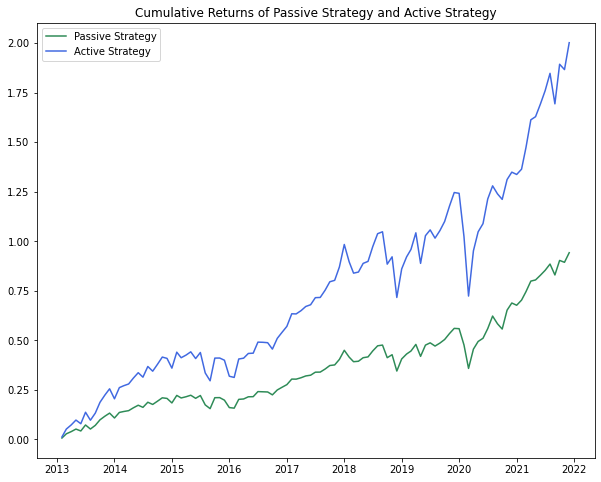

In [33]:
plot_cumulative_returns(data[data.yyyymm > "01-01-2013"], 'passive_strategy', 'active_strategy', 'Passive Strategy', 'Active Strategy')

#### **(b)** What is the alpha and beta of the strategy? Is the alpha economically and statistically large?

In [34]:
import statsmodels.api as sm

endog = data['active_strategy']
exog = sm.add_constant(data['r_actual'])

reg = sm.OLS(endog, exog).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:        active_strategy   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                 1.566e+04
Date:                Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                        17:56:42   Log-Likelihood:                 4416.7
No. Observations:                1571   AIC:                            -8829.
Df Residuals:                    1569   BIC:                            -8819.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.111      0.2

In [35]:
print(f"Alpha: {round(reg.params['const'],4)}")
print(f"Beta: {round(reg.params['r_actual'],4)}")

Alpha: 0.0004
Beta: 0.9322


### **3.** Come up with a new predictor of the equity premium.

We decided to explore the relationship between Bond corporate spreads and Equity returns. For that we will use the following variables: corpr (plain corporate spread); corpr_lag (corporate spread lagged by one month) and gcl (arithmetic return of corpr_lag).

In [36]:
data3 = data_original.drop('csp', axis=1)
data3['corpr_lag'] = data3['corpr'].shift(1)
data3['gcl'] = data3.corpr_lag.pct_change()
data3['r_actual'] = np.log(data3.Index) - np.log(data3.Index.shift(1))
data3 = data3.dropna()

In [37]:
data = data3.iloc[:,[0,1,10,13,17,18,19]].reset_index(drop=True)
data.head(5)

,yyyymm,Index,Rfree,corpr,corpr_lag,gcl,r_actual
0,1926-12-01,13.49,0.0028,0.0056,0.0057,-0.412371,0.016443
1,1927-01-01,13.21,0.0025,0.0056,0.0056,-0.017544,-0.020975
2,1927-02-01,13.84,0.0026,0.0069,0.0056,0.000000,0.046589
3,1927-03-01,13.93,0.0030,0.0083,0.0069,0.232143,0.006482
4,1927-04-01,14.17,0.0025,0.0055,0.0083,0.202899,0.017082


Explore relationship between the three referred features and returns as linear.

In [38]:
endog = data['Index']
exog = sm.add_constant(data['corpr'])

reg = sm.OLS(endog, exog).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Index   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5904
Date:                Sat, 06 May 2023   Prob (F-statistic):              0.442
Time:                        17:56:42   Log-Likelihood:                -9285.3
No. Observations:                1141   AIC:                         1.857e+04
Df Residuals:                    1139   BIC:                         1.858e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        521.9046     25.199     20.711      0.0

In [39]:
exog = sm.add_constant(data['corpr_lag'])

reg = sm.OLS(endog, exog).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Index   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9526
Date:                Sat, 06 May 2023   Prob (F-statistic):              0.329
Time:                        17:56:42   Log-Likelihood:                -9285.1
No. Observations:                1141   AIC:                         1.857e+04
Df Residuals:                    1139   BIC:                         1.858e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        520.6895     25.200     20.663      0.0

In [40]:
exog = sm.add_constant(data.gcl.replace(np.inf, 0).replace(-np.inf, 0))

reg = sm.OLS(endog, exog).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Index   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.003297
Date:                Sat, 06 May 2023   Prob (F-statistic):              0.954
Time:                        17:56:42   Log-Likelihood:                -9285.6
No. Observations:                1141   AIC:                         1.858e+04
Df Residuals:                    1139   BIC:                         1.859e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        526.3298     24.538     21.450      0.0

Create Stratgy functions.

In [41]:
# Compute corporate spread strategy returns

def corpr_returns(obs, col, wt_list):  # wt_list is a list containing the weight - deleverage - threshold combination
    bull_weight = wt_list[0]
    deleverage = wt_list[1]
    threshold = wt_list[2]
    asset_r = obs['r_actual']
    corp_sp = obs[col]
    if corp_sp < threshold:
        ret = bull_weight*asset_r
    else:
        delev_w = bull_weight + deleverage
        ret = delev_w*asset_r
    return ret

In [42]:
non_lag = 'corpr'
lag = 'corpr_lag'
gcl = 'gcl'

Optimize Sharpe Ratio for each strategy.

In [43]:
# Define the constraint function
def constraint_func(wt_list):
    return wt_list[0] - wt_list[1]  # Ensure that bull_weight - deleverage >= 0

# Define the constraint object
constraint = {'type': 'ineq', 'fun': constraint_func}

In [44]:
# Function to optimize SR according to weight on risky asset

def SR_wcalc(wt_list):
    strategy_returns = data.apply(lambda x: corpr_returns(x, non_lag, wt_list), axis=1)
    sr_strategy = (strategy_returns.mean() * 12) / (strategy_returns.std() * np.sqrt(12))
    return -(sr_strategy)

wt0 = [1.2, -0.4, data.corpr.mean()]
sol1 = minimize(SR_wcalc, wt0, constraints=constraint)
print(sol1)

     fun: -0.42711984986945895
     jac: array([ 0.03453537, -0.03453537,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 20
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([1.36881976, 1.36881976, 0.00515986])


In [45]:
def SR_wcalc(wt_list):
    strategy_returns = data.apply(lambda x: corpr_returns(x, lag, wt_list), axis=1)
    sr_strategy = (strategy_returns.mean() * 12) / (strategy_returns.std() * np.sqrt(12))
    return -(sr_strategy)

sol2 = minimize(SR_wcalc, wt0, constraints=constraint)
print(sol2)

     fun: -0.35712465574374
     jac: array([ 0.00249855, -0.00249858,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 28
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([1.54703483, 1.54703483, 0.00515986])


In [46]:
mean_gcl = data.gcl.replace(np.inf,0).replace(-(np.inf),0).mean()

In [47]:
def SR_wcalc(wt_list):
    strategy_returns = data.apply(lambda x: corpr_returns(x, gcl, wt_list), axis=1)
    sr_strategy = (strategy_returns.mean() * 12) / (strategy_returns.std() * np.sqrt(12))
    return -(sr_strategy)

wt0 = [1.2, -0.4, mean_gcl]
sol3 = minimize(SR_wcalc, wt0, constraints=constraint)
print(sol3)

     fun: -0.3328126766785203
     jac: array([ 2.09994614e-05, -8.67396593e-05,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 28
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([ 1.39946796,  0.33855991, -0.03303005])


Calculate returns for each strategy.

In [48]:
optimal_wt1 = sol1.x
optimal_wt2 = sol2.x
optimal_wt3 = sol3.x

data['passive_strategy'] = data.apply(lambda x: passive_returns(x), axis=1)
data['cs_strategy'] = data.apply(lambda x: corpr_returns(x, non_lag, optimal_wt1), axis=1)
data['cs_strategy_lag'] = data.apply(lambda x: corpr_returns(x, lag, optimal_wt2), axis=1)
data['gcs_strategy'] = data.apply(lambda x: corpr_returns(x, gcl, optimal_wt3), axis=1)

data.head()

,yyyymm,Index,Rfree,corpr,corpr_lag,gcl,r_actual,passive_strategy,cs_strategy,cs_strategy_lag,gcs_strategy
0,1926-12-01,13.49,0.0028,0.0056,0.0057,-0.412371,0.016443,0.009866,0.045015,0.050875,0.023011
1,1927-01-01,13.21,0.0025,0.0056,0.0056,-0.017544,-0.020975,-0.012585,-0.057421,-0.064897,-0.036454
2,1927-02-01,13.84,0.0026,0.0069,0.0056,0.000000,0.046589,0.027953,0.127543,0.144149,0.080973
3,1927-03-01,13.93,0.0030,0.0083,0.0069,0.232143,0.006482,0.003889,0.017745,0.020055,0.011266
4,1927-04-01,14.17,0.0025,0.0055,0.0083,0.202899,0.017082,0.010249,0.046765,0.052854,0.029689


In [49]:
def annualized_returns(col, df=data):
    return df[col].mean() * 12

def annualized_vol(col, df=data):
    return df[col].std() * np.sqrt(12)

def sharpe_ratio(col, df=data):
    return annualized_returns(col) / annualized_vol(col)

In [50]:
print(f"Passive strategy annualized returns: {round(annualized_returns('passive_strategy', data)*100,3)} %")
print(f"CS strategy annualized returns: {round(annualized_returns('cs_strategy', data)*100,3)} %")
print(f"CS Lag strategy annualized returns: {round(annualized_returns('cs_strategy_lag', data)*100,3)} %")
print(f"CS Growth strategy annualized returns: {round(annualized_returns('gcs_strategy', data)*100,3)} % \n")

print(f"Passive strategy annualized volatility: {round(annualized_vol('passive_strategy', data)*100,3)} %")
print(f"CS strategy annualized volatility: {round(annualized_vol('cs_strategy', data)*100,3)} %")
print(f"CS Lag strategy annualized volatility: {round(annualized_vol('cs_strategy_lag', data)*100,3)} %")
print(f"CS Growth strategy annualized volatility: {round(annualized_vol('gcs_strategy', data)*100,3)} % \n")

print(f"Passive strategy SR: {round(sharpe_ratio('passive_strategy', data),3)}")
print(f"CS strategy SR: {round(sharpe_ratio('cs_strategy', data),3)}")
print(f"CS Lag strategy SR: {round(sharpe_ratio('cs_strategy_lag', data),3)}")
print(f"CS Growth strategy SR: {round(sharpe_ratio('gcs_strategy', data),3)}")

Passive strategy annualized returns: 3.713 %
CS strategy annualized returns: 16.965 %
CS Lag strategy annualized returns: 15.111 %
CS Growth strategy annualized returns: 9.341 % 

Passive strategy annualized volatility: 11.215 %
CS strategy annualized volatility: 39.72 %
CS Lag strategy annualized volatility: 42.314 %
CS Growth strategy annualized volatility: 28.068 % 

Passive strategy SR: 0.331
CS strategy SR: 0.427
CS Lag strategy SR: 0.357
CS Growth strategy SR: 0.333


#### Check existance of alpha for each strategy.

In [51]:
endog = data['cs_strategy']
exog = sm.add_constant(data['r_actual'])

reg = sm.OLS(endog, exog).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:            cs_strategy   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     9882.
Date:                Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                        17:56:44   Log-Likelihood:                 2147.5
No. Observations:                1141   AIC:                            -4291.
Df Residuals:                    1139   BIC:                            -4281.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      3.430      0.0

In [52]:
endog = data['cs_strategy_lag']

reg = sm.OLS(endog, exog).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:        cs_strategy_lag   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     9119.
Date:                Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                        17:56:44   Log-Likelihood:                 2034.4
No. Observations:                1141   AIC:                            -4065.
Df Residuals:                    1139   BIC:                            -4055.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.310      0.1

In [53]:
endog = data['gcs_strategy']

reg = sm.OLS(endog, exog).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           gcs_strategy   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.092e+05
Date:                Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                        17:56:44   Log-Likelihood:                 3857.9
No. Observations:                1141   AIC:                            -7712.
Df Residuals:                    1139   BIC:                            -7702.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.109e-05      0.000      0.331      0.7

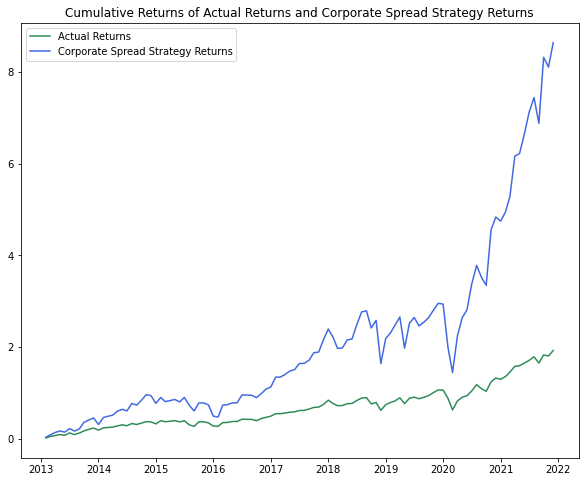

In [54]:
plot_cumulative_returns(data[data.yyyymm > "01-01-2013"], 'r_actual', 'cs_strategy', 'Actual Returns', 'Corporate Spread Strategy Returns')